# Regularizers as memory

The greatest challenge in modern AI research is the limiting returns computational work. 
While the greatest advances can only be afforded by large technology firms, even they 
cannot afford to push results further. A clear plateau has developed. 
Insufficient computational efficiency motivates a return to theory, begs a question: 
_where is waste most significant?_ 

The advent of catestrophic forgetting shows raw, non-compressed information must be continually re-applied 
if it is not to be forgotten. If important information could be preserved--even partially--we would expect 
more efficient computation. In short, _this work targets the realization of memory_.

Regularized likelihood equations have a Lagrangian form, so implicitly describe geometric constraints on estimates.
For example, here's an estimate constrained to an L2-sphere in $\Theta$-space.

$$ \hat \theta_{L_2} = \text{arg max}_{\theta \in \Theta} n^{-1} \sum_{i=1}^n \log f_X(X_i;\theta) - \lambda \| \theta \|_2^2 $$

In this work, we'll generalize the regularizer $\| \cdot \|_2^2$ to support alternative geometries, 
in attempting to construct numerically convenient memory approximations. 
Particulary, we'll seek to approximate the following equation.
Note that it introduces quadratic geometric constraints on the estimate. 

$$ \hat \theta = \text{arg max}_{\theta \in \Theta} n^{-1} \sum_{i=1}^n \log f_X(X_i;\theta) - \frac{\lambda}{2} (\theta - \theta_0)^T \mathcal{I}_{\theta_0} (\theta - \theta_0) $$

## RL-reweighted (RLR) estimates 

This first estimate is designed to improve efficiency of sampling in reinforcement learning (RL) by 
up-weighting more-important observations. We'll use this estimate:

$$ \hat \theta_{RLR} = \hat \theta_{n_1+n_2} = \text{arg max}_\theta \left( \sum_{i=1}^{n_1+n_2} \| \hat r_i \|_2^{2b} \right)^{-1} \left( \sum_{i=n_1+1}^{n_1+n_2} \| \hat r_i \|_2^{2b} \log f_X(X_i; \theta) - \sum_{i=1}^{n_1} \frac{\lambda}{2} (\theta - \hat \theta_{n_1+n_2-1})^T H_i (\theta - \hat \theta_{n_1+n_2-1}) \right) $$

where 
- $n_1$ is the number of priviously observed sameples, 
- $n_2$ is the number of newly observed samples, 
- $\hat r_i$ is the estimated reward for observation $i$, 
- $b > 0$ is a bias term,  
- $H_i = \| \hat r_i \|^{2b}_2 \left( \nabla_\theta \log f_X(X_j; \theta)|_{\theta = \hat \theta_{j-1}} \right) \left( \nabla_\theta \log f_X(X_j; \theta)|_{\theta = \hat \theta_{j-1}} \right)^T$ is a Hessian approximation, and
- $\hat \theta_0$ is an initial estimate guess, commonly required in optimization routines. 

Define $ M:= \sum_{i=1}^{n_1}(\theta - \theta_{n_1+n_2-1})^TH_i(\theta - \theta_{n_1+n_2-1})$, which we'll refer to as the "memory term". 
The key heuristic is that $M$, a quadratic regularizer, approximates large-sample likelihoods under maximization. 
This insight can be seen through a Taylor approximation near true $\theta$, designated $\theta_T$.

$\hat \theta_{MLE} = \text{arg max}_\theta n^{-1} \sum_{i=1}^n \log f_X(X_i;\theta) $

$ \approx \text{arg max}_\theta n^{-1}\sum_i \log f_X(X_i; \theta_T) + n^{-1}\sum_i (\theta - \theta_T)^T \nabla_\theta \log f_X(X_i; \theta_T) + n^{-1}2^{-1} \sum_i (\theta - \theta_T)^T (\nabla_\theta^2 \log f_X(X_i; \theta_T))(\theta - \theta_T) $

$ \approx \text{arg max}_\theta n^{-1}\sum_i \log f_X(X_i; \theta_T) + 0 + n^{-1}2^{-1} \sum_i (\theta - \theta_T)^T (\nabla_\theta^2 \log f_X(X_i; \theta_T))(\theta - \theta_T) $

$ \approx \text{arg max}_\theta n^{-1}2^{-1} \sum_i (\theta - \theta_T)^T (\nabla_\theta^2 \log f_X(X_i; \theta_T))(\theta - \theta_T) $

This work basically tests the quality of our $M \approx \sum_i (\theta - \theta_T)^T (\nabla_\theta)^2 \log f_X(X_i; \theta_T)(\theta - \theta_T) $ heuristic.
If true, then we should see that the quadratic regularizer, $M$, affects memory through geometric constraints on the estimator.

Later, we'll experiment with recency bias and rank reductions for $M$.

Notice that $\hat \theta_{RLR}$ is asymptotically equivalent to a redistributed sampling, 
with more observations when they are more important. 
Hence, the essence of this computational efficiency strategy is to 
- add frequency bias to important observations, 
- and preserve their information via geometric estimator constraints.

## $M$ and almost-stationary processes

$M$ is an asymptotic result, so only applies when observations are sufficiently many and produced by a stationary or i.i.d process.
While most applied asymptotic theory assumes $\theta_T$ is static, it could also be possible to work with a $\theta_{T_n}$ on a continuous path in $\Theta$ over $n$.
Let us define an _almost-stationary process_ $X_n$ as satisfying the following.

$$ \forall \tau \in \mathbb{R}, \left(t_1, t_2, \ldots, t_m\right) \in \mathbb{R}_{\geq 0}^m, \mathbb{P}\left[ X_{t_{1+\tau}}, X_{t_{2+\tau}}, \ldots, X_{t_{m+\tau}} ; \theta_{t_1+\tau} \right] \text{is continuous in } \tau$$

The question of whether $\theta_{T_n}$ moves "too quickly" is dependent on an given process. 
If, for $n$ large, $M$ still approximates $\sum_i (\theta - \theta_{T_n})^T (\nabla_\theta^2 \log f_X(X_i; \theta_{T_n}))(\theta - \theta_{T_n})$, 
then we'll say $\theta_{T_n}$ is "sufficiently slow". Here are some examples relating to **transfer learning**.
- If we withheld digits 1 & 2 from MNIST for the first 10000 observations, then started including them afterward, 
we should expect $\theta_{T_n}$ to move too quickly. 
- As reinforcement learning (RL) agent explores its world, it's sampling process indeed deforms, albeit slowly. 
This context should have good opportunities for sufficiently slow changes in $\theta_{T_n}$. 
So, our experiments will focus on RL applications.

Developing transfer learning mechanisms for RL is particularly valuable, 
since it is frequently imagined to be a path to artificial general intelligence (AGI).

Side node: almost-stationary process theory clearly needs development. 
My experience has taught me to test the value of theoretical hypotheses before developing them, 
since theoretical development is far more expensive than computational experimentation.
I am confident in this hypothesis, because my previous theoretical developments are very similar. 
Any new proofs would not be very novel, and would be mere adaptations of prior work. 

## Experiment 1: Cartpole

We start with a _very_ simple example, proving-out concepts.

In [1]:
## Define model 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random 

INPUT_DIM = 4
N_ACTIONS = 2
MAX_SAMPLE = 5000
DISCOUNT = .95 
EPS = 1e-5
EXPLORE_PROBABILITY_FUNC = lambda idx: 0.999**idx 
BATCH_SIZE = 100 
LEARNING_RATE = 0.001 
GRAD_CLIP = 10.0 
LBFGS = False 

class Model(nn.Module): 
    def __init__(self, 
            input_dim=INPUT_DIM, 
            n_actions=N_ACTIONS, 
            discount = DISCOUNT, 
            max_sample=MAX_SAMPLE, 
            eps=EPS): 
        super(Model, self).__init__() 
        ## store config 
        self.input_dim = input_dim 
        self.n_actions = n_actions 
        self.discount = discount 
        self.max_sample = max_sample 
        self.eps = eps 
        ## init feed forward net 
        self.fc1 = nn.Linear(input_dim, 40) 
        self.fc1_bn = nn.BatchNorm1d(40) 
        self.fc2 = nn.Linear(40, 40) 
        self.fc2_bn = nn.BatchNorm1d(40) 
        self.fc3 = nn.Linear(40, n_actions) 
        ## init data structures 
        self.observations = [] 
        if LBFGS: 
            self.optimizer = optim.LBFGS(self.parameters(), history_size=50) ## RAM req = O(history_size * model_dim) 
        else: 
            ## LBFGS was giving nan parameters 
            self.optimizer = optim.Adam(self.parameters(), lr=LEARNING_RATE) 
            pass 
        pass 

    def forward(self, x): 
        x = self.fc1(x)
        x = self.fc1_bn(x) 
        x = torch.tanh(x) 
        x = self.fc2(x) 
        x = self.fc2_bn(x)  
        x = torch.tanh(x) 
        x = self.fc3(x) 
        return x 
    
    def get_action(self, env_state): 
        env_state = torch.tensor(env_state).float() 
        env_state = env_state.reshape([1, -1]) 
        predicted_reward_per_action_idx = self.forward(env_state) 
        return int(predicted_reward_per_action_idx.argmax()) 
    
    def store_observation(self, observation): 
        if len(observation) > self.max_sample: 
            observation = observation[1:] 
        self.observations.append(observation) 
        pass 
    
    def clear_observations(self): 
        self.observations = [] 
        pass 
    
    def __sample(self, sample_max=None): 
        ## random sample 
        obs = self.observations 
        if sample_max is not None: 
            if sample_max < len(self.observations): 
                obs = random.sample(self.observations, sample_max) 
        ## unpack samples 
        samples = [ (torch.tensor(env_state).float(), \
                torch.tensor(reward).float(), \
                torch.tensor(done).int(), \
                torch.tensor(prev_env_state).float(), \
                torch.tensor(action).int()) for \
                (env_state, reward, done, info, prev_env_state, action) in obs] 
        ## build matrices 
        env_state = torch.stack([obs[0] for obs in samples], dim=0) ## inserts dim 0 
        observed_rewards = torch.stack([obs[1] for obs in samples], dim=0) 
        done = torch.stack([obs[2] for obs in samples], dim=0) 
        prev_env_state = torch.stack([obs[3] for obs in samples], dim=0) 
        action = torch.stack([obs[4] for obs in samples], dim=0).reshape([-1, 1]).type(torch.int64) 
        ## calculate target 
        self.eval() 
        predicted_rewards = self.forward(env_state) 
        predicted_rewards = torch.max(predicted_rewards, dim=1, keepdim=True).values.reshape([-1]) 
        target = observed_rewards + (1 - done) * self.discount * predicted_rewards 
        target = target.reshape([-1, 1]).detach() 
        ## calculate prediction  
        self.train() 
        self.zero_grad() 
        predicted_rewards = self.forward(prev_env_state) 
        prediction = predicted_rewards.gather(1, action) 
        return prediction, target 
    
    def get_parameter_vector(self): 
        return nn.utils.parameters_to_vector(self.parameters()) 
    
    def optimize(self, max_iter=None, batch_size=None): 
        iter_n = 0 
        n_dels = 30 
        dels = [None]*n_dels 
        continue_iterating = True 
        halt_method = None 
        loss_f = None 
        mean_reward = None 
        while continue_iterating: 
            prev_theta = self.get_parameter_vector() 
            predicted, target = self.__sample(batch_size) 
            mean_reward = predicted.mean() 
            loss = F.mse_loss(predicted, target) 
            loss_f = float(loss) 
            loss.backward() 
            if not LBFGS: 
                ## lbfgs really doesn't like this 
                nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP) 
            ## lbfgs must re-evaluate target, hence lambda 
            if LBFGS:
                self.optimizer.step(lambda: float(F.mse_loss(predicted, target))) 
            else:
                self.optimizer.step() 
                pass 
            updated_theta = self.get_parameter_vector() 
            ## decide to continue iterating or not 
            if max_iter is not None: 
                if iter_n > max_iter: 
                    ## halt: iters have hit limit 
                    continue_iterating = False 
                    halt_method = 'max-iter' 
            if iter_n >= n_dels: 
                ## test convergence with chebyshev ineq 
                dels = dels[1:] + [(updated_theta - prev_theta).abs().sum()] 
                sigma = torch.tensor(dels).square().mean().sqrt() 
                if (sigma/self.eps)**2 < .95: 
                    ## halt: convergance 
                    continue_iterating = False 
                    halt_method = 'cauchy-convergence' 
            else: 
                ## collect data for variance estimate 
                dels[iter_n] = (updated_theta - prev_theta).abs().sum() 
                pass 
            iter_n += 1 
            pass 
        return loss_f, halt_method, mean_reward  

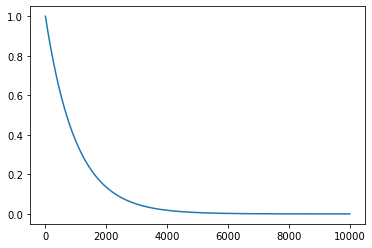

In [2]:
## Define experiment 
import gym 
from tqdm import tqdm 
import numpy as np 
import matplotlib.pyplot as plt 

model = Model() 

env = gym.make('CartPole-v1') 
env_state = env.reset() 
last_start = 0 
last_survival = 0 
n_restarts = 0 
total_reward = 0 
survivals = [] 
total_iters = 10000 

plt.plot([EXPLORE_PROBABILITY_FUNC(idx) for idx in range(total_iters)])
plt.show()

In [3]:
## run experiment 
iters = tqdm(range(total_iters), disable=False) 
for iter_idx in iters: 
  prev_env_state = env_state 
  if EXPLORE_PROBABILITY_FUNC(iter_idx) < np.random.uniform(): 
    ## explore 
    action = env.action_space.sample() 
  else: 
    ## exploit 
    model.eval() 
    action = model.get_action(env_state) 
    pass 
  env_state, reward, done, info = env.step(action) 
  if done:
    total_reward = -1 
    reward = -10
  else: 
    total_reward += reward 
    pass 
  observation = env_state, reward, done, info, prev_env_state, action 
  model.store_observation(observation) 

  if iter_idx > 30 and iter_idx % 1 == 0: 
    #loss, halt_method, mean_reward = model.optimize(max_iter=100, batch_size=BATCH_SIZE) 
    loss, halt_method, mean_reward = model.optimize(max_iter=10, batch_size=600) 
    loss = float(loss) 
    mean_reward = float(mean_reward) 
    param_nan = model.get_parameter_vector().isnan().sum() 
    iters.set_description(f'n_restarts: {n_restarts}, last_survival: {last_survival}, '+\
        f'loss: {round(loss,4)}, halt: {halt_method}, mean_reward: {round(mean_reward,2)}, action: {action}')#+\
        #f'param_nan: {param_nan}, last action: {action}') 
    pass 

  if done: 
    env_state = env.reset() 
    last_survival = iter_idx - last_start 
    survivals.append(last_survival) 
    last_start = iter_idx 
    n_restarts += 1 
    pass 
  pass 
env.close() 

n_restarts: 420, last_survival: 16, loss: 11.5393, halt: max-iter, mean_reward: 21.11, action: 0: 100%|██████████| 10000/10000 [1:01:45<00:00,  2.70it/s]


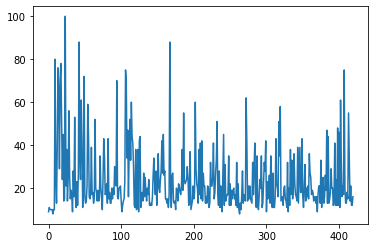

In [4]:
import matplotlib.pyplot as plt
plt.plot(survivals)
plt.show()

In [5]:
for idx, s in enumerate(survivals): 
    print(f'{s} ' , end='') 
    if (idx+1) % 40 == 0: 
        print('') 

9 11 10 10 10 10 8 10 10 80 24 13 40 76 65 29 71 78 49 24 45 14 15 100 21 38 14 24 56 26 15 19 17 9 28 16 53 16 11 23 
12 26 88 35 24 61 43 11 23 72 16 13 14 21 59 45 16 15 18 39 17 18 13 16 52 20 18 14 19 14 15 35 20 16 10 24 43 35 17 18 
22 13 43 15 18 13 13 20 15 20 17 30 25 21 70 16 15 20 20 21 14 9 12 14 15 23 75 70 34 47 16 38 52 33 60 44 41 30 12 11 
38 10 11 38 9 42 44 11 16 18 14 27 16 25 18 14 20 17 24 12 12 13 12 16 26 34 23 17 28 12 21 36 20 18 24 28 42 27 45 26 
28 15 15 13 15 11 17 88 23 11 26 27 14 13 14 10 20 19 14 22 21 18 17 21 38 19 55 24 22 23 24 30 25 12 20 37 10 12 14 21 
15 18 60 29 22 20 13 38 17 41 15 42 14 27 21 21 13 16 13 21 20 11 13 32 21 21 25 41 15 18 27 33 51 17 12 28 11 21 16 9 
27 45 12 31 14 16 17 17 35 12 22 12 19 15 19 20 15 17 12 32 11 22 10 8 13 10 17 28 13 17 15 14 62 41 14 21 15 21 15 14 
13 32 17 30 41 17 11 35 12 10 17 24 20 35 11 13 22 32 28 42 9 23 15 20 26 13 35 15 11 27 11 11 16 43 22 20 16 51 35 58 
14 15 16 12 20 21 15 14 11 32 9 20 12 3

In [6]:
import gym
env = gym.make("CartPole-v1")
observation = env.reset()
action = env.action_space.sample()
observation, reward, done, info = env.step(action)
env.close()

print(observation)
print(reward)
print(done)
print(info)
print(action)

[-0.00972075 -0.23375029  0.01023419  0.33213522]
1.0
False
{}
0


## REATTEMPT FOLLOWS

In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0)


env.reset()
#plt.figure()
#plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
#           interpolation='none')
#plt.title('Example extracted screen')
#plt.show()

array([-0.02793252, -0.02686731,  0.01948532, -0.00983969])

In [3]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

ImportError: 
    Error occurred while running `from pyglet.gl import *`
    HINT: make sure you have OpenGL install. On Ubuntu, you can run 'apt-get install python-opengl'.
    If you're running on a server, you may need a virtual frame buffer; something like this should work:
    'xvfb-run -s "-screen 0 1400x900x24" python <your_script.py>'
    

In [ ]:
num_episodes = 50
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
#env.render()
env.close()
plt.ioff()
plt.show()